Clustering Mash distances to obtain clonal groups for all Salmonella

In [1]:
library('FactoMineR')
library('factoextra')
library('readxl')
library('dplyr')

Loading required package: ggplot2
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
mash_dist_file = '../data/interim/mash_distance_matrix.csv'
meta_excel_file = '../data/raw/GenotypicAMR_Master.xlsx'

In [5]:
distances <- read.csv(mash_dist_file, header=TRUE, row.names=1, stringsAsFactors=FALSE)
options(warn=-1)
metadf = read_excel(meta_excel_file, na='-')
options(warn=0)

In [6]:
serodf <- as.data.frame(metadf['serovar'])
serodf$serovar <- tolower(serodf$serovar)
srrs <- sapply(metadf['run'], as.character)
rownames(serodf) <- srrs
serodf[is.na(serodf$serovar),] = 'No serovar'

In [26]:
pcs <- PCA(distances, scale.unit=FALSE, ncp = 20, graph = FALSE)

fp = list()
cfit = list()
for(k in 5:15) {
    cat(k)
    cat("\n")
    clu <- HCPC(pcs, graph = FALSE, nb.clust=k)
    clustdf <- clu$data.clust['clust']
    clustdf = merge(clustdf, serodf, by=0, all.x=TRUE, all.y=FALSE)
    cluster_counts = clustdf %>% group_by(serovar) %>% summarise(n_clusters = n_distinct(clust))
    # Find serovars split across clusters
    splitserovars = cluster_counts$serovar[cluster_counts['n_clusters'] >= 2]
    # For serovars split across clusters, count number in each cluster
    splitcounts = clustdf %>% count(serovar, clust) %>% filter(serovar %in% splitserovars) %>% arrange(desc(serovar))
    # Count all genomes in non-majority clusters
    misclassified = splitcounts %>% group_by(serovar) %>% filter(n != max(n)) %>% filter(serovar != 'No serovar')
    fp[[k]] = sum(misclassified['n'])
    cfit[[k]] = clu
}

5
6
7
8
9
10
11
12
13
14
15


In [27]:
# fp = number of genomes that are in wrong clusters, i.e. the correct cluster is the cluster with the most serovar genomes
print(fp)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
[1] 68

[[6]]
[1] 76

[[7]]
[1] 68

[[8]]
[1] 84

[[9]]
[1] 56

[[10]]
[1] 58

[[11]]
[1] 63

[[12]]
[1] 69

[[13]]
[1] 73

[[14]]
[1] 74

[[15]]
[1] 72



In [43]:
clustdf <- cfit[[9]]$data.clust['clust']

In [44]:
table(clustdf)

clustdf
  1   2   3   4   5   6   7   8   9 
513 124 201 183 395 290 283 239  32 

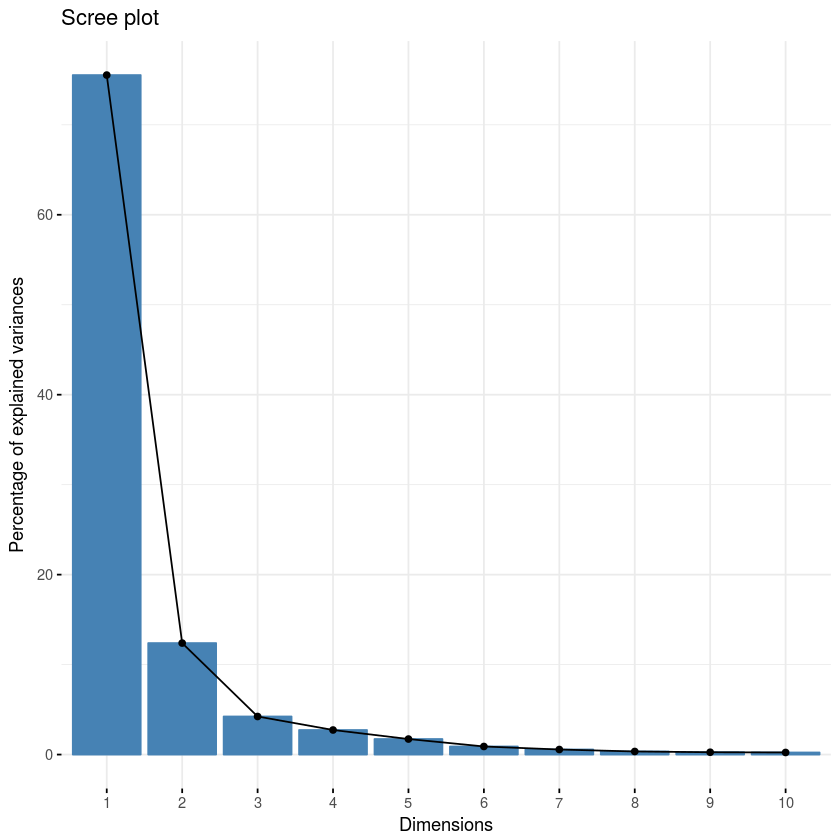

In [45]:
fviz_eig(pcs)

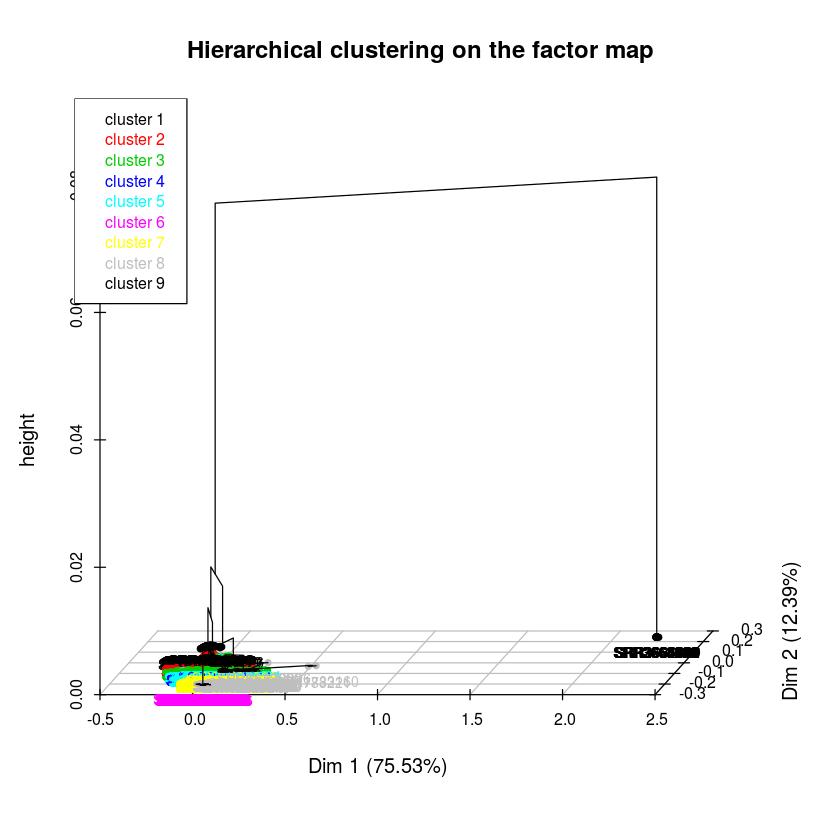

In [46]:
plot(cfit[[9]], choice = "3D.map")